##### Imports

In [33]:
import preprocess
import sample
import cluster
import nn
import k_means
import fuzzy_c_means
import mountain

import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
%reload_ext autoreload
%autoreload 2

np.random.seed(420)

##### Read Data

In [2]:
classify = True
if classify:
    file = 'iris.csv'
    index_col, header = 0, 0
else:
    file = 'examen.csv'
    index_col, header = None, None

data, N_S, axes_names, indices = preprocess.get_data(file, header, index_col)
X_S, Y_S, revert_X, revert_Y = preprocess.preprocess(data, classify)
revert_Y = list(revert_Y)

### Sample

##### PDF properties

In [3]:
pdf_info = sample.pdf_info(indices)

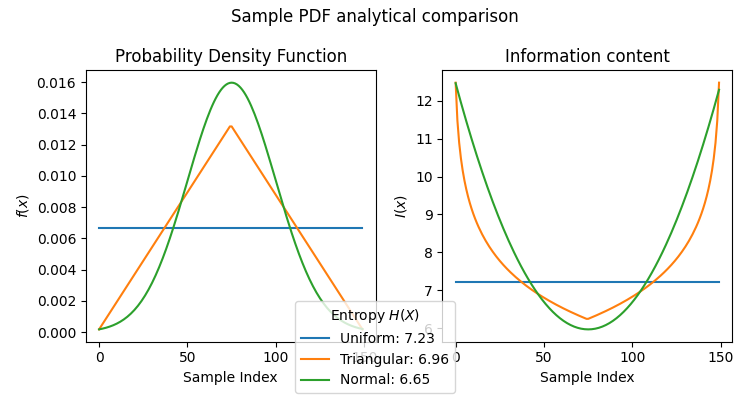

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(7.5, 4), layout="tight")
fig.suptitle("Sample PDF analytical comparison")
ax[0].set_title("Probability Density Function")
ax[1].set_title("Information content")
cluster.axis_labels(ax[0], "Sample Index", "$f(x)$")
cluster.axis_labels(ax[1], "Sample Index", "$I(x)$")

for name, info in pdf_info.items():
    ax[0].plot(indices, info["F"], label=f"{name}: {info['H']:.2f}")
    ax[1].plot(indices, info["I"])
fig.legend(title="Entropy $H(X)$", loc="lower center")

##### Sampling data

In [5]:
p_sample = sample.sample(indices)
p_index = p_sample["Uniform"]
partition = {k: (X_S[:, v], Y_S[:, v]) for k, v in p_index.items()}

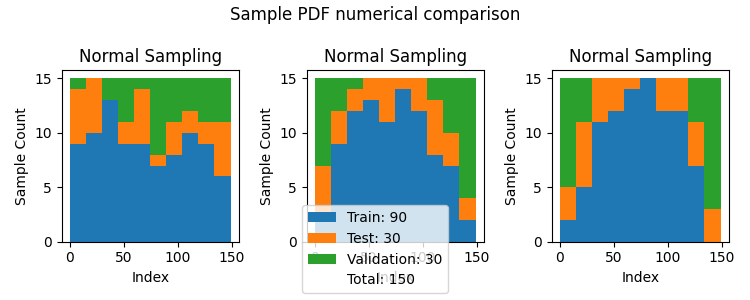

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(7.5, 3), layout="tight")
fig.suptitle("Sample PDF numerical comparison")
for ax_pdf, (name_pdf, partition_pdf) in zip(ax, p_sample.items()):
    ax_pdf.set_title(f"{name} Sampling")
    cluster.axis_labels(ax_pdf, 'Index', 'Sample Count')
    ax_pdf.hist(partition_pdf.values(), stacked=True, bins=10)
legend = fig.legend([f"{k}: {len(v)}" for k, v in p_index.items()]
                    + [f"Total: {N_S}"], loc="lower center")
legend.legendHandles[-1].set_visible(False)

### Neural Network

##### Train

In [7]:
hidden = [2, 2]
epochs = 1000

W, B, delta_nn, Y_nn, E_nn = nn.train(partition, "Train", 
    hidden=hidden, epochs=epochs, classify=classify, logs=True)

c:\Users\Orfy\Desktop\AI 2022-2\AI-pipeline\cluster.py:57: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(*X[:3, xF], color=cmap(cnorm(c)),


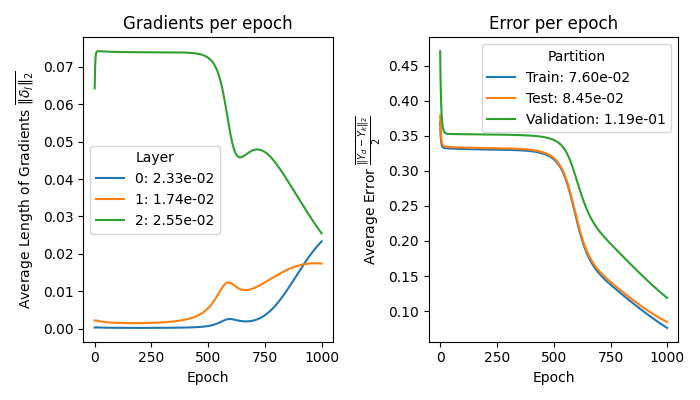

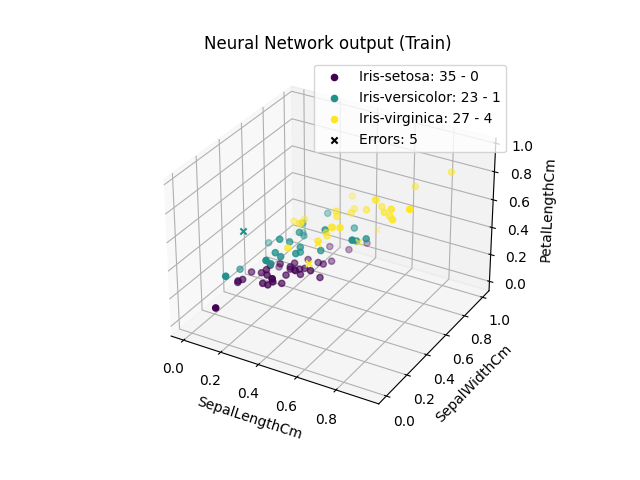

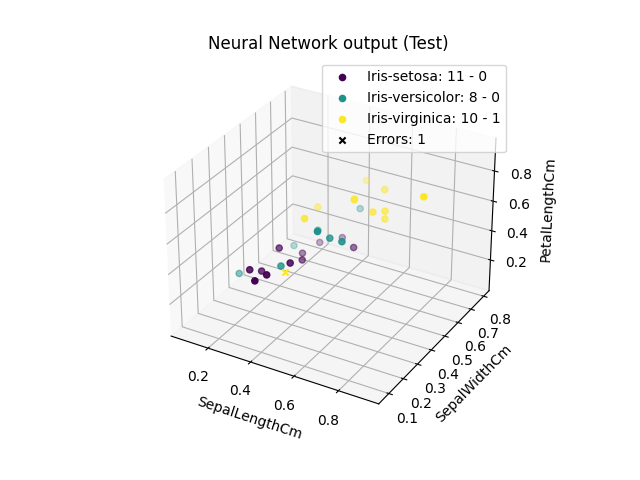

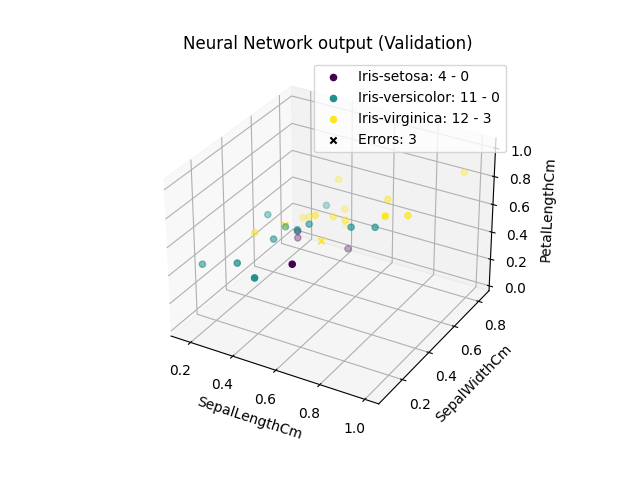

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(7, 4), layout="tight")
ax[0].set_title("Gradients per epoch")
ax[0].plot(range(epochs), delta_nn, 
        label=[f"{l}: {d:.2e}" for l, d in enumerate(delta_nn[-1])])
ax[0].legend(title="Layer")
cluster.axis_labels(ax[0], "Epoch",
    "Average Length of Gradients $\\overline{\\Vert\\delta_l\\Vert_2}$")

ax[1].set_title("Error per epoch")
for p_name in p_index.keys():
    ax[1].plot(range(epochs), E_nn[p_name], 
        label=f"{p_name}: {E_nn[p_name][-1]:.2e}")
ax[1].legend(title="Partition")
cluster.axis_labels(ax[1], "Epoch",
    "Average Error $\\frac{\\overline{\\Vert Y_d - Y_k\\Vert_2}}{2}$")

for name, XY in partition.items():
    U, _ = nn.eval(XY[0], W, B, cluster=True)
    cluster.plot(XY[0], U, Ud=XY[1],
                 title=f"Neural Network output ({name})",
                 cluster_names=revert_Y, axes_names=axes_names)

# Unsupervised Learning

### K-Means

In [9]:
U, C = k_means.run(3, partition["Train"][0], 0.002)

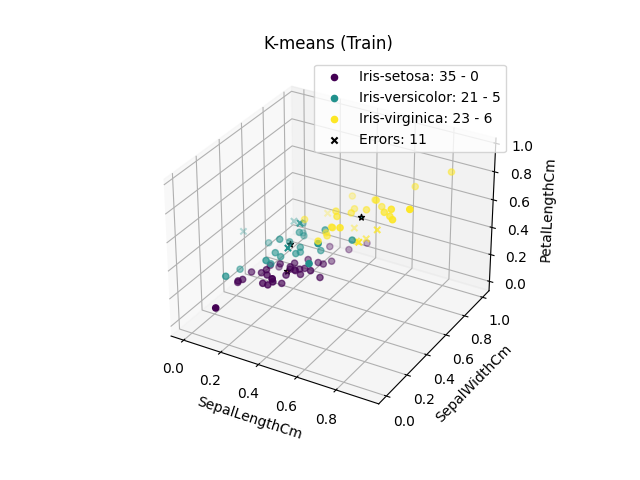

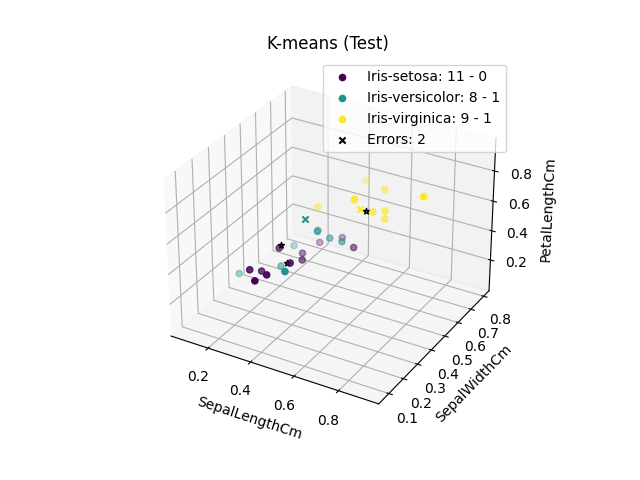

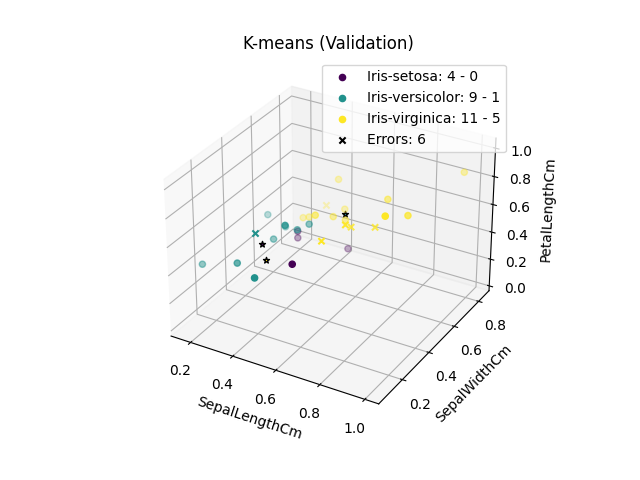

In [10]:
for name, XY in partition.items():
    U = k_means.eval(XY[0], C)
    if U.shape[0] == XY[1].shape[0]:
        U = cluster.match(U, XY[1])
        Ud = XY[1]
    else:
        Ud = None
    cluster.plot(XY[0], U, Ud=Ud, C=C, title=f"K-means ({name})",
        cluster_names=revert_Y, axes_names=axes_names)


### Fuzzy C-means

In [11]:
m = 2
U, C = fuzzy_c_means.run(3, partition["Train"][0], m, 0.002)

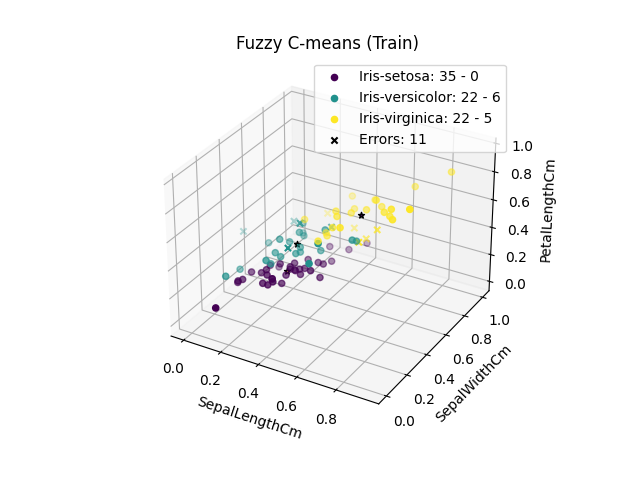

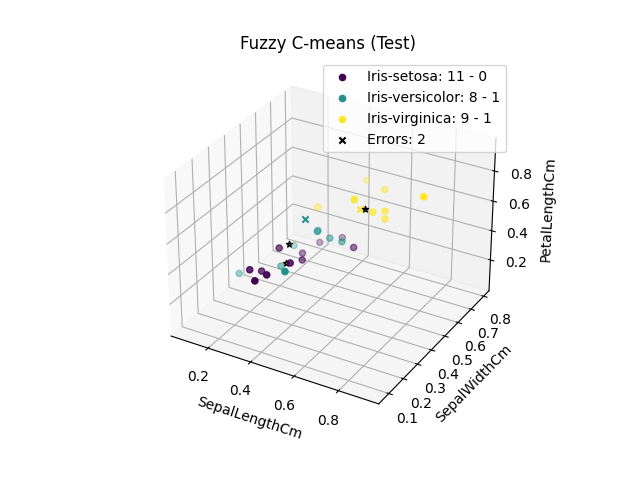

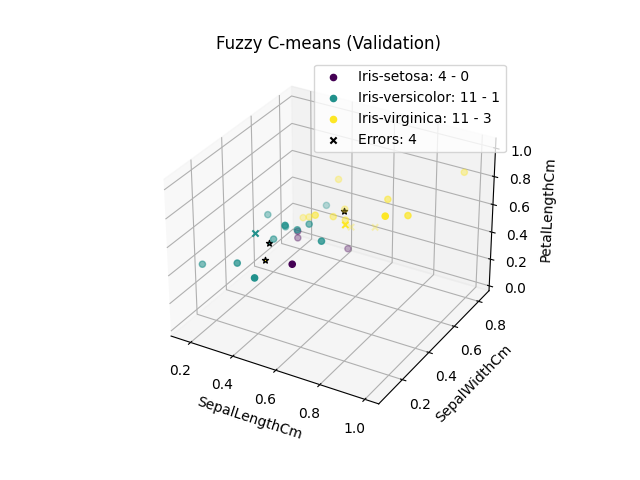

In [12]:
for name, XY in partition.items():
    U = fuzzy_c_means.eval(XY[0], C, m)
    if U.shape[0] == XY[1].shape[0]:
        U = cluster.match(U, XY[1])
        Ud = XY[1]
    else:
        Ud = None
    cluster.plot(XY[0], U, Ud=Ud, C=C, title=f"Fuzzy C-means ({name})",
        cluster_names=revert_Y, axes_names=axes_names)

### Mountain Clustering

In [13]:
C = mountain.run(partition["Train"][0], 1, 1, 0.05, n=10)

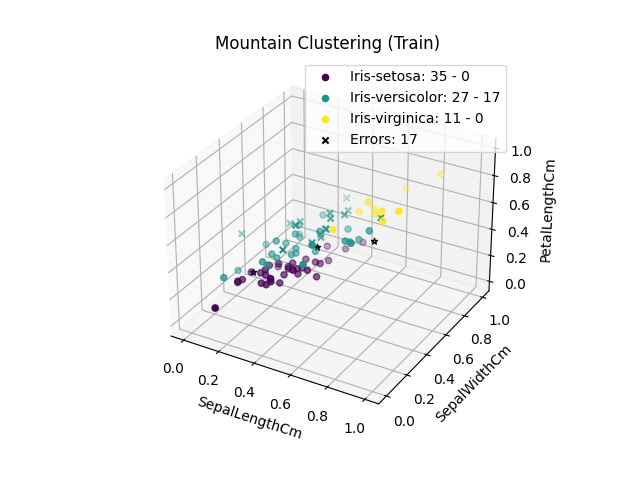

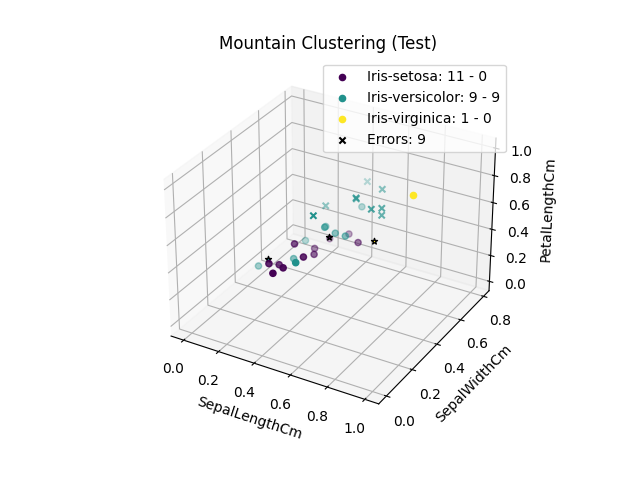

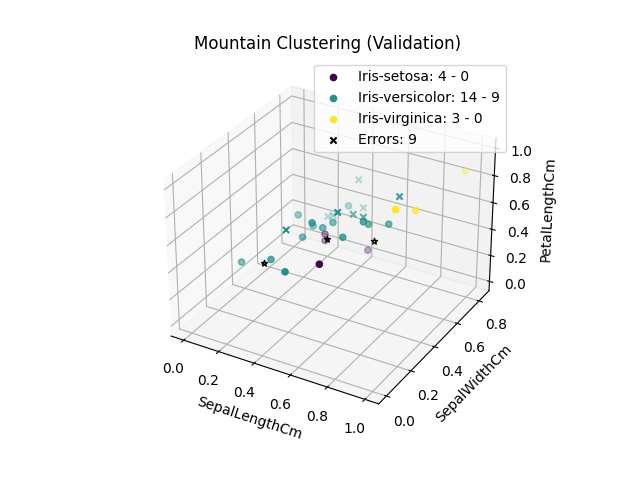

In [14]:
for name, XY in partition.items():
    U = k_means.eval(XY[0], C)
    if U.shape[0] == XY[1].shape[0]:
        U = cluster.match(U, XY[1])
        Ud = XY[1]
    else:
        Ud = None
    cluster.plot(XY[0], U, Ud=Ud, C=C, title=f"Mountain Clustering ({name})",
                 cluster_names=revert_Y, axes_names=axes_names)

### Substractive Clustering

In [63]:
C = mountain.run(partition["Train"][0], 1.1, 1, 0, substractive=True)

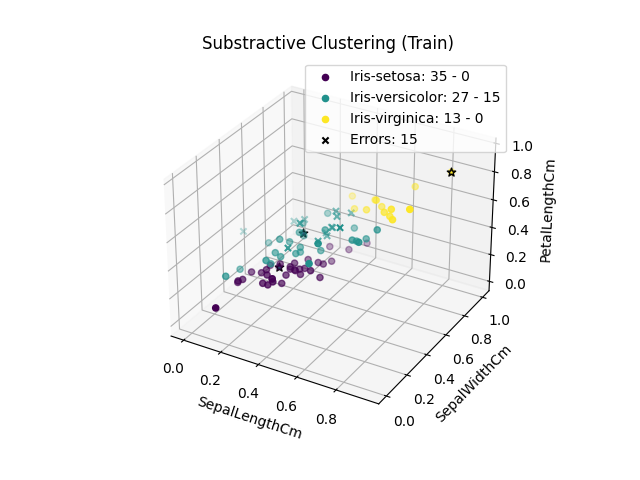

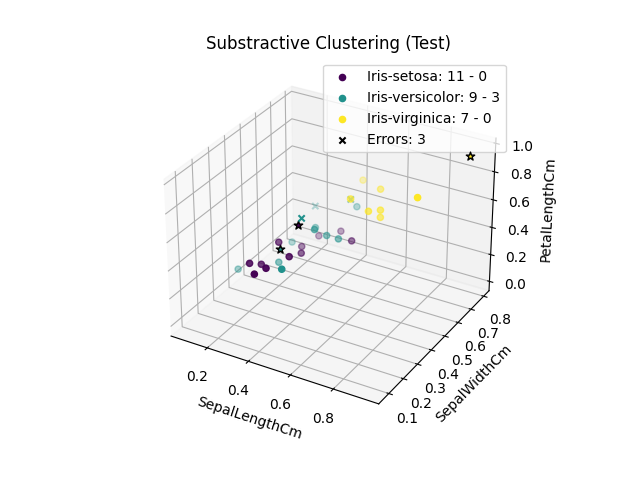

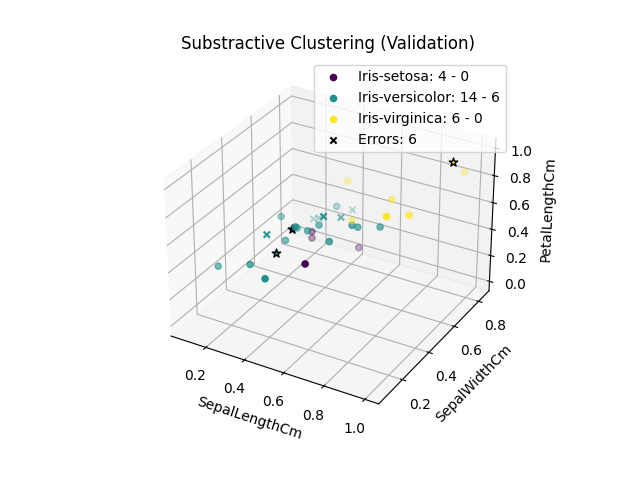

In [64]:
for name, XY in partition.items():
    U = k_means.eval(XY[0], C)
    if U.shape[0] == XY[1].shape[0]:
        U = cluster.match(U, XY[1])
        Ud = XY[1]
    else:
        Ud = None
    cluster.plot(XY[0], U, Ud=Ud, C=C, title=f"Substractive Clustering ({name})",
                 cluster_names=revert_Y, axes_names=axes_names)